<a href="https://www.kaggle.com/code/oscarm524/ps-s3-ep8-eda-modeling?scriptVersionId=119856992" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a id="table"></a>
<h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Table of Contents</h1>

[1. Notebook Versions](#Notebook-Versions)

[2. Data Description](#Data-Description)

[3. Loading Libraries](#Loading-Libraries)

[4. Reading Data Files](#Reading-Data-Files)

[5. Data Exploration](#Data-Exploration)

[6. Baseline Modeling 1.0](#Baseline-Modeling-1.0)

[7. Baseline Modeling 2.0](#Baseline-Modeling-2.0)

<a id="table"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Notebook Versions</h1>

1. Version 1 (02/20/2023)
    * EDA 
    * Baseline 1.0
    
2. Version 2 (02/21/2023)
    * Baseline 2.0 (clarity_scaled)
    
3. Version 3 (02/21/2023)
    * Updating baseline 2.0 (cut_scaled and color_scaled) 

<a id="table"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Data Description</h1>

This is a synthetic dataset generated from the [Gemstone Price Prediction](https://www.kaggle.com/datasets/colearninglounge/gemstone-price-prediction) dataset. These are the descriptions of the variables in this dataset:

<ul>
    <li> Carat: Carat weight of the cubic zirconia. </li>
    <li> Cut: Describe the cut quality of the cubic zirconia. Quality is increasing order Fair, Good, Very Good,... </li>
    <li> Color: Colour of the cubic zirconia. With D being the best and J the worst. </li>
    <li> Clarity: Cubic zirconia clarity refers to the absence of the Inclusions and Blemishes. </li>
    <li> Depth: The Height of a cubic zirconia, measured from the Culet to the table, divided by its average Girdle.  </li>
    <li> Table: The Width of the cubic zirconia's Table expressed as a Percentage of its Average Diameter.. </li>
    <li> Price: The Price of the cubic zirconia. </li>
    <li> X: Length of the cubic zirconia in mm. </li>
    <li> Y: Width of the cubic zirconia in mm. </li>
    <li> Z: Height of the cubic zirconia in mm. </li>
</ul>

 
<a id="table"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Loading Libraries</h1>    

In [1]:
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

from tqdm import tqdm

from functools import partial
import scipy as sp

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns
import plotly.express as px

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import RFE, RFECV
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

<a id="table"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Reading Data Files</h1> 

In [2]:
train = pd.read_csv('../input/playground-series-s3e8/train.csv')
test = pd.read_csv('../input/playground-series-s3e8/test.csv')
submission = pd.read_csv('../input/playground-series-s3e8/sample_submission.csv')

print('The dimession of the train dataset is:', train.shape)
print('The dimession of the test dataset is:', test.shape)

The dimession of the train dataset is: (193573, 11)
The dimession of the test dataset is: (129050, 10)


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193573 entries, 0 to 193572
Data columns (total 11 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       193573 non-null  int64  
 1   carat    193573 non-null  float64
 2   cut      193573 non-null  object 
 3   color    193573 non-null  object 
 4   clarity  193573 non-null  object 
 5   depth    193573 non-null  float64
 6   table    193573 non-null  float64
 7   x        193573 non-null  float64
 8   y        193573 non-null  float64
 9   z        193573 non-null  float64
 10  price    193573 non-null  int64  
dtypes: float64(6), int64(2), object(3)
memory usage: 16.2+ MB


In [4]:
train.head()

,id,carat,cut,color,clarity,depth,table,x,y,z,price
0,0,1.52,Premium,F,VS2,62.2,58.0,7.27,7.33,4.55,13619
1,1,2.03,Very Good,J,SI2,62.0,58.0,8.06,8.12,5.05,13387
2,2,0.70,Ideal,G,VS1,61.2,57.0,5.69,5.73,3.50,2772
3,3,0.32,Ideal,G,VS1,61.6,56.0,4.38,4.41,2.71,666
4,4,1.70,Premium,G,VS2,62.6,59.0,7.65,7.61,4.77,14453


In [5]:
train.describe()

,id,carat,depth,table,x,y,z,price
count,193573.000000,193573.000000,193573.000000,193573.000000,193573.000000,193573.000000,193573.000000,193573.000000
mean,96786.000000,0.790688,61.820574,57.227675,5.715312,5.720094,3.534246,3969.155414
std,55879.856166,0.462688,1.081704,1.918844,1.109422,1.102333,0.688922,4034.374138
min,0.000000,0.200000,52.100000,49.000000,0.000000,0.000000,0.000000,326.000000
25%,48393.000000,0.400000,61.300000,56.000000,4.700000,4.710000,2.900000,951.000000
50%,96786.000000,0.700000,61.900000,57.000000,5.700000,5.720000,3.530000,2401.000000
75%,145179.000000,1.030000,62.400000,58.000000,6.510000,6.510000,4.030000,5408.000000
max,193572.000000,3.500000,71.600000,79.000000,9.650000,10.010000,31.300000,18818.000000


In [6]:
test.head()

,id,carat,cut,color,clarity,depth,table,x,y,z
0,193573,0.35,Ideal,D,VS2,62.3,56.0,4.51,4.54,2.82
1,193574,0.77,Very Good,F,SI2,62.8,56.0,5.83,5.87,3.68
2,193575,0.71,Ideal,I,VS2,61.9,53.0,5.77,5.74,3.55
3,193576,0.33,Ideal,G,VVS2,61.6,55.0,4.44,4.42,2.73
4,193577,1.20,Very Good,I,VS2,62.7,56.0,6.75,6.79,4.24


In [7]:
test.describe()

,id,carat,depth,table,x,y,z
count,129050.000000,129050.000000,129050.000000,129050.000000,129050.000000,129050.000000,129050.000000
mean,258097.500000,0.789256,61.820522,57.239608,5.711767,5.716336,3.531802
std,37253.670457,0.462502,1.080249,1.918908,1.109666,1.102485,0.690749
min,193573.000000,0.200000,53.200000,51.000000,0.000000,0.000000,0.000000
25%,225835.250000,0.400000,61.300000,56.000000,4.700000,4.710000,2.900000
50%,258097.500000,0.700000,61.900000,57.000000,5.700000,5.720000,3.530000
75%,290359.750000,1.030000,62.400000,58.000000,6.510000,6.510000,4.030000
max,322622.000000,4.500000,70.600000,70.000000,10.140000,10.140000,31.800000


> <div class="alert alert-block alert-info">
<b>💡</b> There are no missing values neither in the train nor test datasets. Also, by a quick eye-ball comparison of the summary statistics of the train and test datasets, they seem to have similar distributions. However, a more detailed exploration will be conducted in the next section. 
</div>

<a id="table"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Data Exploration</h1>

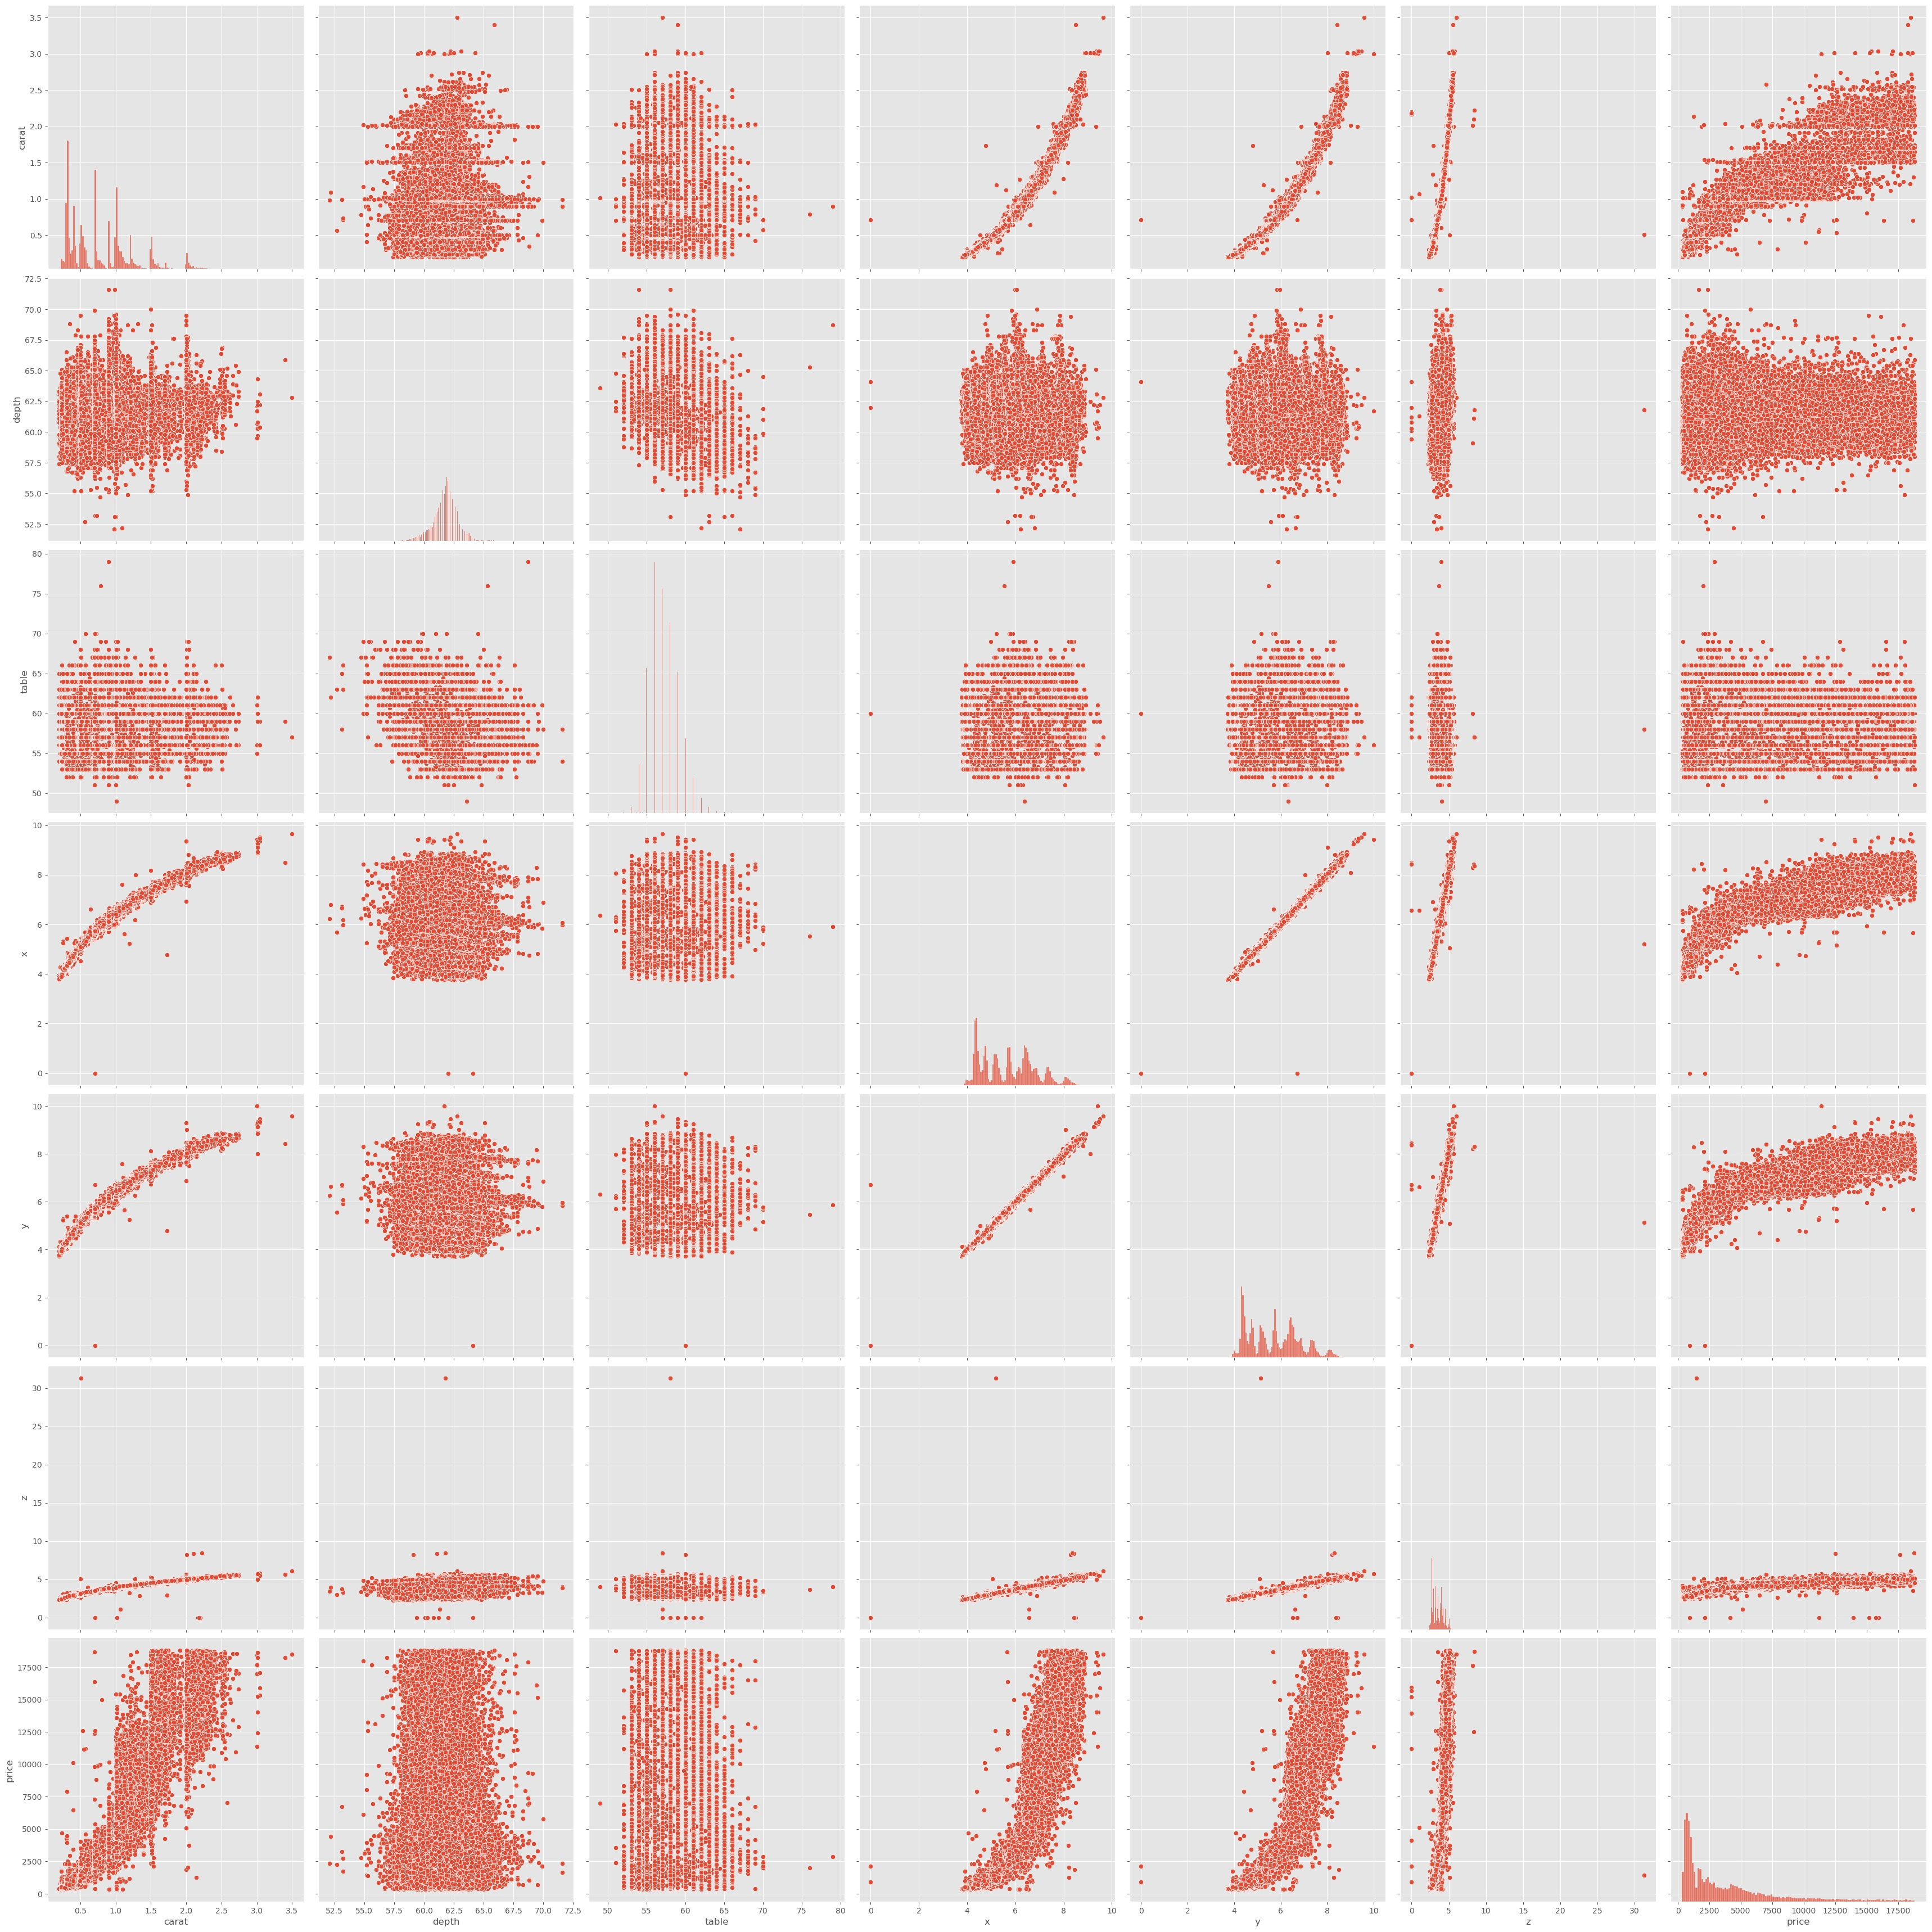

In [8]:
sns.pairplot(train.drop(columns = ['id', 'cut', 'color', 'clarity'], axis = 1), height = 5);

> <div class="alert alert-block alert-info">
<b>💡 From the above charts, we notice a couple of interesting relationships:</b><br> 
> <ul>
    <li> There is a clear relationship between carat and x, y, and z. </li>
    <li> There is linear relationhip among x, y and z. </li>
    <li> It seems that there is an exponetial relationship between price and x, y, and z </li>
</ul>
</div>

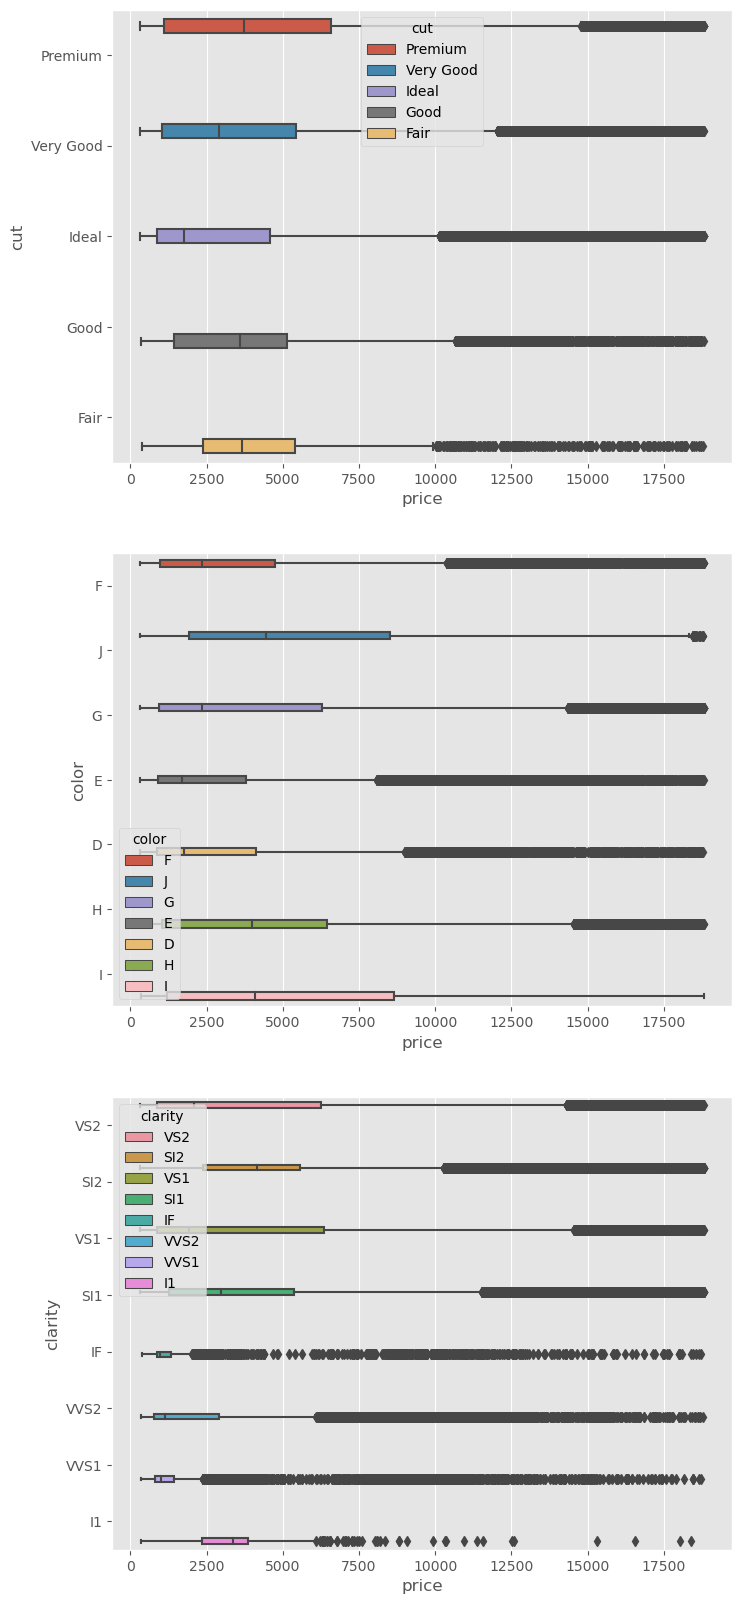

In [9]:
fig, axes = plt.subplots(3, 1, figsize = (8, 20))

sns.boxplot(ax = axes[0], y = 'cut', x = 'price', hue = 'cut', data = train)
sns.boxplot(ax = axes[1], y = 'color', x = 'price', hue = 'color', data = train)
sns.boxplot(ax = axes[2], y = 'clarity', x = 'price', hue = 'clarity', data = train);

> <div class="alert alert-block alert-info">
<b>💡</b> From the above side-by-side there is no much to learn. There are a lot of outliers and overlapping among the distributions of price.
</div>

Next, we proceed to explore what features correlate the most with price.

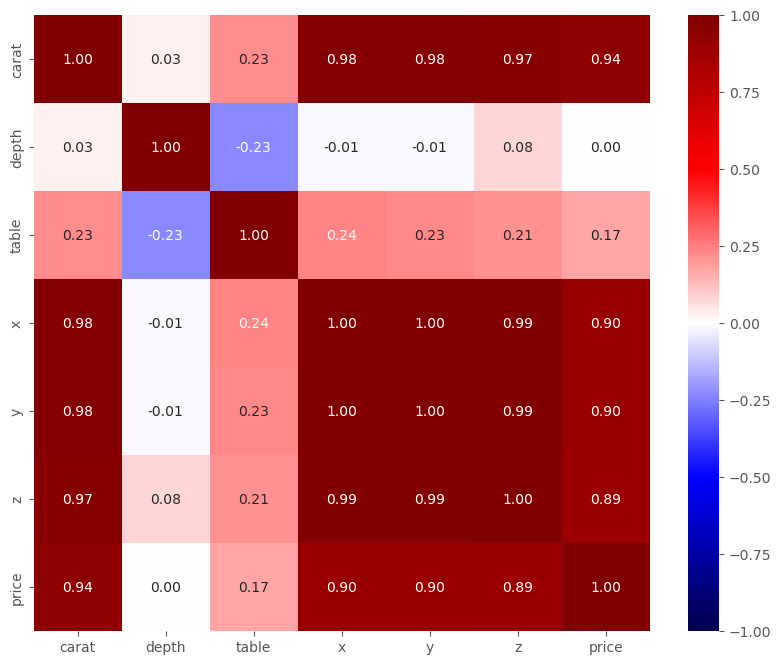

In [10]:
corr_mat = train.drop(columns = ['id', 'cut', 'color', 'clarity'], axis = 1).corr()
f, ax = plt.subplots(figsize = (10, 8))
sns.heatmap(corr_mat, square = True, annot = True, fmt = '.2f', cmap = 'seismic', vmin = -1, vmax = 1);

> <div class="alert alert-block alert-info">
<b>💡</b> From the above heatmap, we see strong correlations between carat, x, y, z, and price, which agrees with the scatter-plots that were previously created.
</div>

Next, we compare the distribution of the train and test datasets.

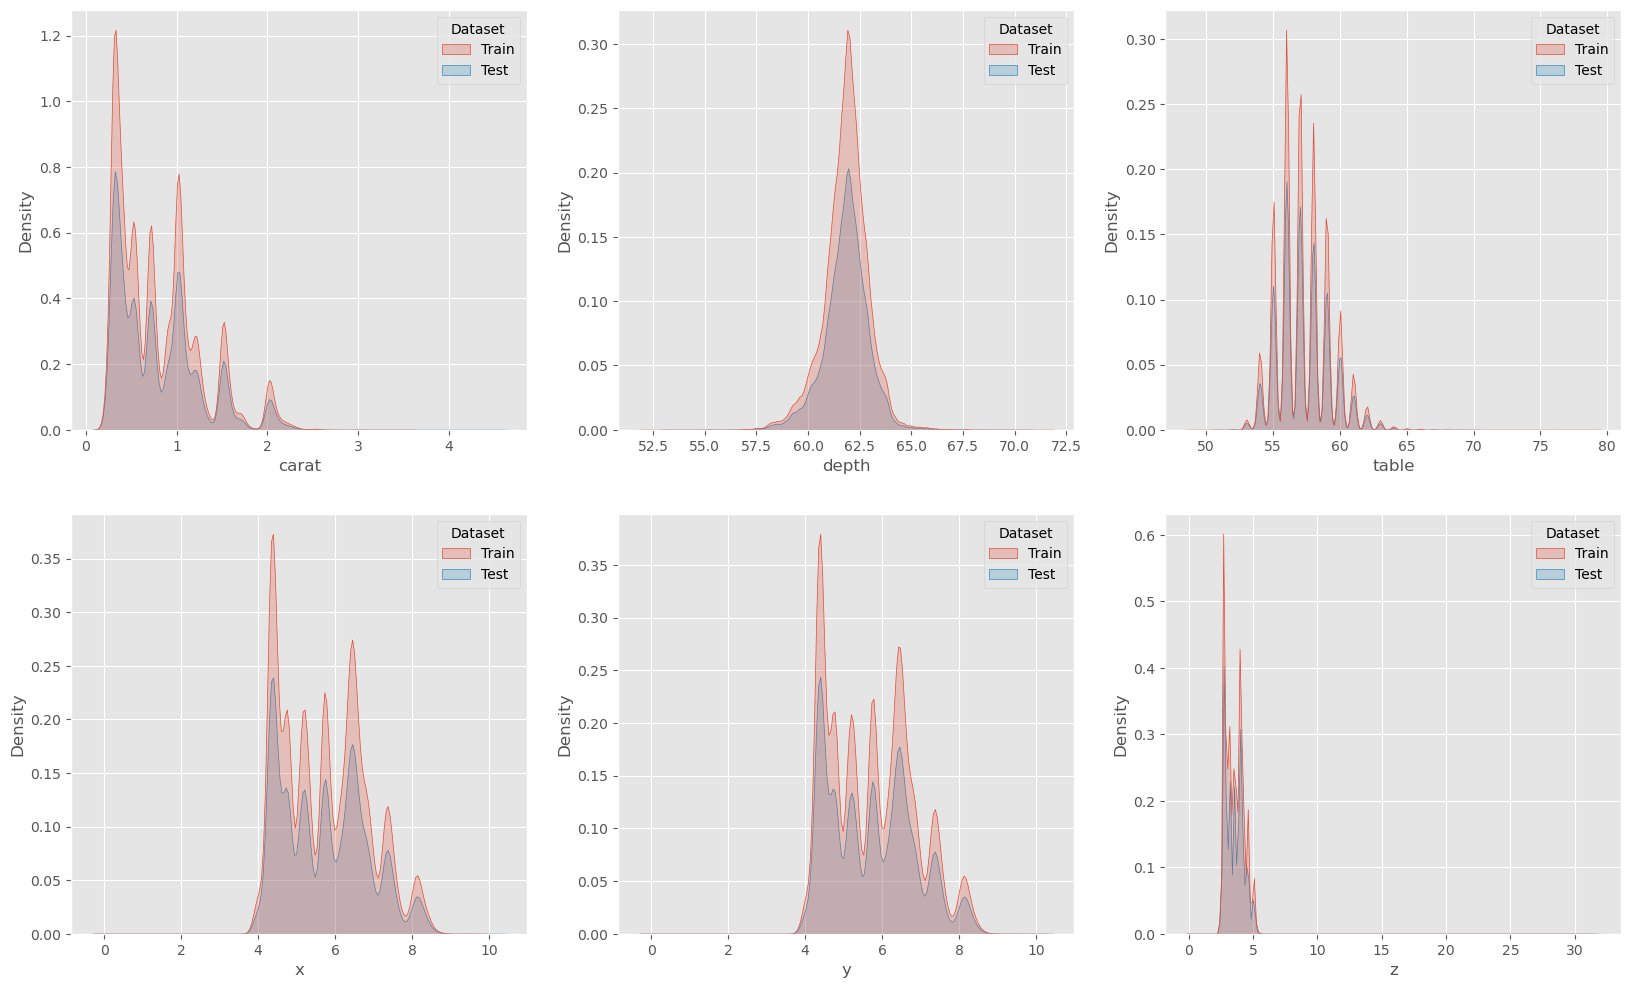

In [11]:
train_vis = train.drop(columns = 'price', axis = 1).reset_index(drop = True).copy()
test_vis = test.copy()

train_vis['Dataset'] = 'Train'
test_vis['Dataset'] = 'Test'
data_tot = pd.concat([train_vis, test_vis], axis = 0).reset_index(drop = True)

fig, axes = plt.subplots(2, 3, figsize = (20, 12))

sns.kdeplot(ax = axes[0, 0], x = 'carat', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[0, 1], x = 'depth', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[0, 2], x = 'table', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[1, 0], x = 'x', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[1, 1], x = 'y', hue = 'Dataset', data = data_tot, fill = True)
sns.kdeplot(ax = axes[1, 2], x = 'z', hue = 'Dataset', data = data_tot, fill = True);

> <div class="alert alert-block alert-info">
<b>💡</b> From the above density plots, we see that the distributions of the features are very similar in the train and test datasets.
</div>

In [12]:
train_dup = train.drop(columns = ['id', 'price'], axis = 1)
test_dup = test.drop(columns = ['id'], axis = 1)
duplicates = pd.merge(train_dup, test_dup, on = train_dup.columns.tolist()[0:9])

print('There are ', duplicates.shape[0], ' rows that appear in the train and test dataset.\n')
print(duplicates.head())

There are  1598  rows that appear in the train and test dataset.

   carat    cut color clarity  depth  table     x     y     z
0   0.52  Ideal     D     SI1   61.7   57.0  5.14  5.17  3.18
1   0.52  Ideal     E     VS2   62.5   57.0  5.15  5.17  3.23
2   0.55  Ideal     D     VS2   61.8   56.0  5.26  5.30  3.26
3   0.71  Ideal     E     VS2   61.3   57.0  5.74  5.77  3.53
4   0.71  Ideal     E     VS2   61.3   57.0  5.74  5.77  3.53


<a id="table"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Baseline Modeling 1.0</h1>

In this section, we build a xgboost model with raw features (with minimal transformation).

In [13]:
train_dummies = pd.get_dummies(train[['cut', 'color', 'clarity']])
X = train.drop(columns = ['id', 'cut', 'color', 'clarity', 'price'], axis = 1)
X = pd.concat([X, train_dummies], axis = 1)
Y = train['price']

test_dummies = pd.get_dummies(test[['cut', 'color', 'clarity']])
test_baseline = pd.concat([test.drop(columns = ['id', 'cut', 'color', 'clarity'], axis = 1), test_dummies], axis = 1)

XGB_cv_scores, XGB_imp = list(), list()
preds = list()

## Running 5 times CV
for i in range(5):
#     print(i)
    skf = KFold(n_splits = 5, random_state = 42, shuffle = True)
    
    for train_ix, test_ix in skf.split(X, Y):
        
        ## Splitting the data 
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
                
        ## Building RF model
        XGB_md = XGBRegressor(tree_method = 'gpu_hist',
                              colsample_bytree = 0.7, 
                              gamma = 0.8, 
                              learning_rate = 0.01, 
                              max_depth = 7, 
                              min_child_weight = 10, 
                              n_estimators = 1000, 
                              subsample = 0.7).fit(X_train, Y_train)
        XGB_imp.append(XGB_md.feature_importances_)
        
        ## Predicting on X_test and test
        XGB_pred_1 = XGB_md.predict(X_test)
        XGB_pred_2 = XGB_md.predict(test_baseline)
        
        ## Computing roc-auc score
        XGB_cv_scores.append(mean_squared_error(Y_test, XGB_pred_1, squared = False))
        preds.append(XGB_pred_2)

XGB_cv_score = np.mean(XGB_cv_scores)    
print('The average oof rmse score over 5-folds (run 5 times) is:', XGB_cv_score)

The average oof rmse score over 5-folds (run 5 times) is: 577.9048095341085


We next proceed to visualize the importance of the features under the XGBoost model.

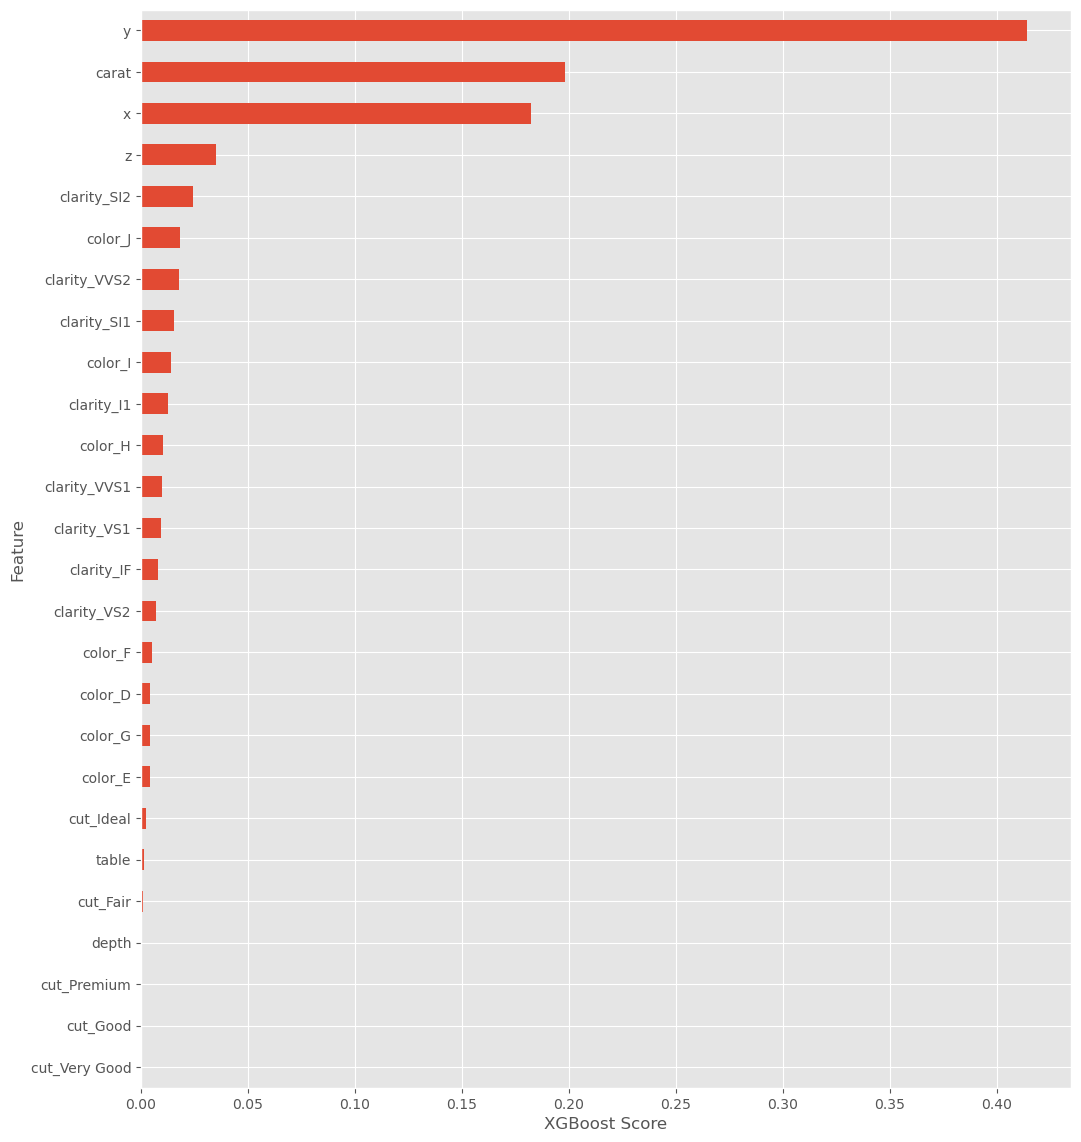

In [14]:
plt.figure(figsize = (12, 14))
pd.DataFrame(XGB_imp, columns = X.columns).apply(np.mean, axis = 0).sort_values().plot(kind = 'barh');
plt.xlabel('XGBoost Score')
plt.ylabel('Feature')
plt.show();               

In [15]:
xgb_preds_test = pd.DataFrame(preds).apply(np.mean, axis = 0)
submission['price'] = xgb_preds_test
submission.head()

,id,price
0,193573,871.117493
1,193574,2513.527100
2,193575,2340.328125
3,193576,819.424927
4,193577,5707.794434


In [16]:
submission.to_csv('XGBoost_baseline_submission.csv', index = False)

<a id="table"></a>
# <h1 style="background-color:lightgray;font-family:newtimeroman;font-size:350%;text-align:center;border-radius: 15px 50px;">Baseline Modeling 2.0</h1>

In this section, I use the baseline 1.0 model as starting point. But, I use the clarity encoding suggusted [here](https://www.kaggle.com/competitions/playground-series-s3e8/discussion/389174) by @craigmthomas.

In [17]:
def updating_labels(df):
    
    df['clarity_scaled'] = df['clarity'].apply(lambda x: 0 if x == "IF" else 1 if x == "VVS1" else 2 if x == "VVS2" else 3 if x == "VS1" else 4 if x == "VS2" else 5 if x == "SI1" else 6 if x == "SI2" else 7)
    df['clarity_scaled'] = df['clarity_scaled'].astype(np.int8)
    
    df['cut_scaled'] = df['cut'].apply(lambda x: 0 if x == 'Fair' else 1 if x == 'Good' else 2 if x == 'Very Good' else 3 if x == 'Premium' else 4)                          
    df['cut_scaled'] = df['cut_scaled'].astype(np.int8) 
    
    df['color_scaled'] = df['color'].apply(lambda x: 0 if x == 'J' else 1 if x == 'I' else 2 if x == 'H' else 3 if x == 'G' else 4 if x == 'F' else 5 if x == 'E' else 6)
    df['color_scaled'] = df['color_scaled'].astype(np.int8)
    
    return df

train2 = updating_labels(train)
train2 = train2.drop(columns = ['cut', 'color', 'clarity'], axis = 1)

test2 = updating_labels(test)
test2 = test2.drop(columns = ['cut', 'color', 'clarity'], axis = 1)

X = train2.drop(columns = ['id', 'price'], axis = 1)
Y = train2['price']

test_baseline2 = test2.drop(columns = ['id'], axis = 1)

XGB_cv_scores, XGB_imp = list(), list()
preds = list()

## Running 5 times CV
for i in range(5):
#     print(i)
    skf = KFold(n_splits = 5, random_state = 42, shuffle = True)
    
    for train_ix, test_ix in skf.split(X, Y):
        
        ## Splitting the data 
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
                
        ## Building RF model
        XGB_md = XGBRegressor(tree_method = 'gpu_hist',
                              colsample_bytree = 0.7, 
                              gamma = 0.8, 
                              learning_rate = 0.01, 
                              max_depth = 7, 
                              min_child_weight = 10, 
                              n_estimators = 1000, 
                              subsample = 0.7).fit(X_train, Y_train)
        XGB_imp.append(XGB_md.feature_importances_)
        
        ## Predicting on X_test and test
        XGB_pred_1 = XGB_md.predict(X_test)
        XGB_pred_2 = XGB_md.predict(test_baseline2)
        
        ## Computing roc-auc score
        XGB_cv_scores.append(mean_squared_error(Y_test, XGB_pred_1, squared = False))
        preds.append(XGB_pred_2)

XGB_cv_score = np.mean(XGB_cv_scores)    
print('The average oof rmse score over 5-folds (run 5 times) is:', XGB_cv_score)

The average oof rmse score over 5-folds (run 5 times) is: 573.2589073808499


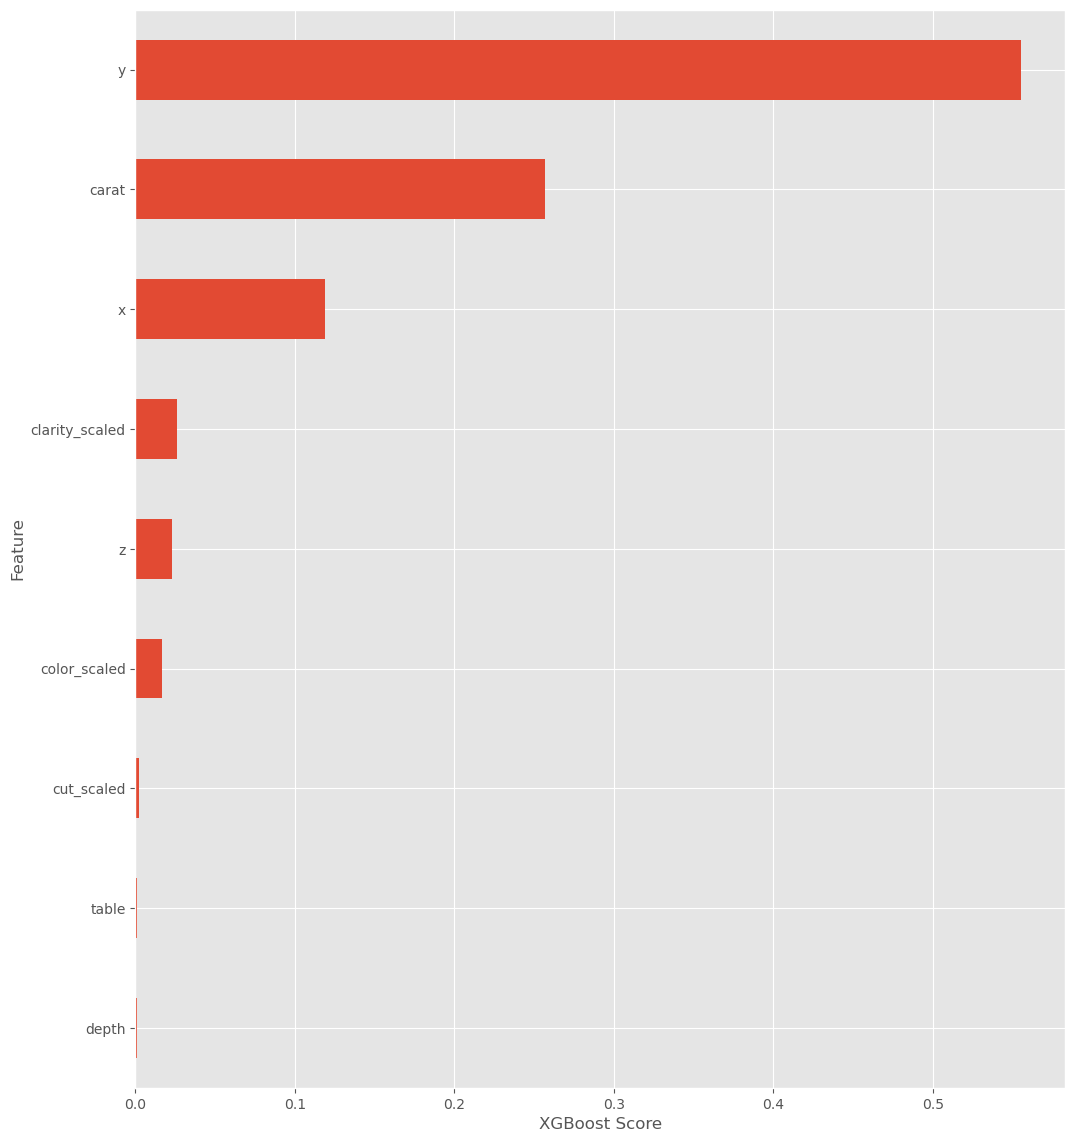

In [18]:
plt.figure(figsize = (12, 14))
pd.DataFrame(XGB_imp, columns = X.columns).apply(np.mean, axis = 0).sort_values().plot(kind = 'barh');
plt.xlabel('XGBoost Score')
plt.ylabel('Feature')
plt.show();               

From the above chart, it seems that `x`, `y`, `z`, `carat` and `clarity_scaled` are the only important features based on the XGBoost model.

In [19]:
xgb_preds_test = pd.DataFrame(preds).apply(np.mean, axis = 0)
submission['price'] = xgb_preds_test
submission.head()

,id,price
0,193573,877.252991
1,193574,2493.455322
2,193575,2331.226318
3,193576,844.860229
4,193577,5768.090820


In [20]:
submission.to_csv('XGBoost_baseline_2_submission.csv', index = False)

# More work coming soon...
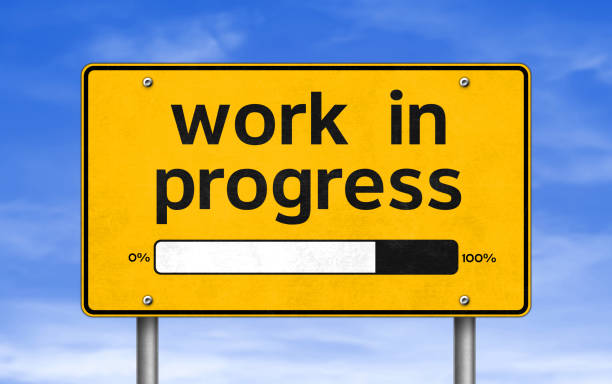